In [1]:
%pylab inline
import sklearn
from scipy import stats

plt.style.use('seaborn')

Populating the interactive namespace from numpy and matplotlib


### 支持向量机

该方法试图利用已有的数据点，在数据点之间“画出一个边界”。

下面直接参考 Jake VanderPlas （Director of Open Software at the University of Washington's eScience institute）的教程：

https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb

# 1. 理念介绍

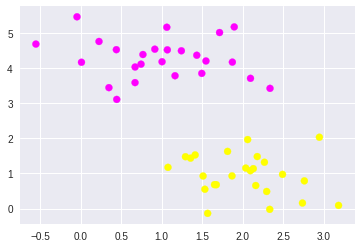

In [3]:
from sklearn import datasets

## 生成 “成团的高斯分布的点，分布在两个中心周围”

X, y = datasets.make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)

plt.scatter(X[:,0], X[:,1], c=y, cmap = 'spring')

#### 一个典型的分类方法会试图寻找分开它们的决策边界，但这样的边界线不是唯一的。比如：

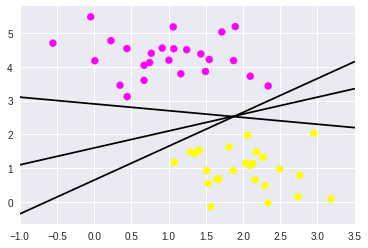

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

#### 上面给出了三种可能的决策边界。在应用于一个新的数据时，可能会得到不同的结果。我们该用哪一个呢？...

#### 支持向量机给出了一种合理的选择方法。

#### 支持向量机不仅给出决策边界，还会考虑演这条线平移产生的"分界区间"

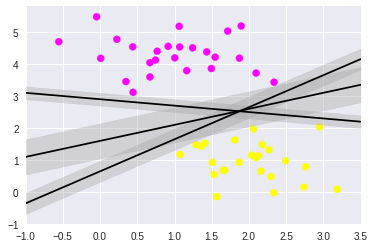

In [19]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

#### 支持向量机会选择那个“能够产生最大决策区间”的边界。

#### 这就是支持向量机(support vector machine, SVM)的主要思想。

# 2. sklearn 实现

In [5]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')

clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### 使用 decision_function 查看 SVM 找到的边界（对应0）以及 margin（对应-1 1 之间）

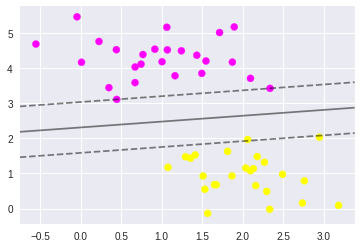

In [6]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

### 虚线“摸”到了三个点，它们构成的向量就称为 support vector (于是就用它来命名这算法了)。sklearn 将它们存储到 supoort_vectors_ 里面

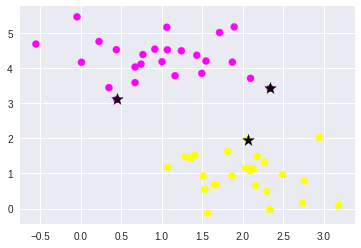

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
#plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=150, marker='*', c='k');

### 下面 ipython 的交互图演示了随样本数目的多少，support vector 的变化
(This is only available in IPython 2.0+, and will not work in a static view)

In [9]:
from ipywidgets import interact

def plot_svm(N=10):
    X, y = datasets.make_blobs(n_samples=500, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 50, 100, 150, 200, 300, 400, 500], kernel='linear');

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 150, 200, 300, 400, 500), value=10), Out…

# 3. 核技巧

### 真正让 svm 大行其道的是它与核（kernel）方法的结合。传统的 svm 无法分类下面的非线性问题：

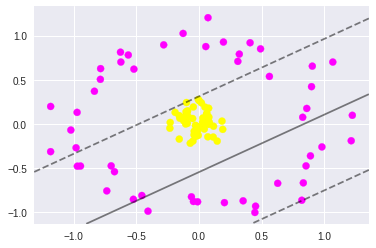

In [12]:
# Make a large circle containing a smaller circle in 2d.
X, y = datasets.make_circles(n_samples=100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

Clearly, no linear discrimination will ever separate these data. 

One way we can adjust this is to apply a kernel, which is some functional transformation of the input data.

### 这时我们可以用一个核来把输入数据在另一个维度上分开。最常用的是 径向基函数核（也称高斯基函数核） **radial basis function**

In [13]:
r = np.exp( -(X[:, 0] ** 2 + X[:, 1] ** 2))

from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azim=(-180, 180));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

### 这真是一个简单好用的方法。SVM中使用径向基函数核可以用 kernel = 'rbf' 实现：

/home/xiaodongli/software/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


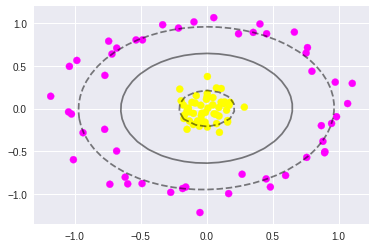

In [26]:
# Make a large circle containing a smaller circle in 2d.

clf = SVC(kernel='rbf').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

/home/xiaodongli/software/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


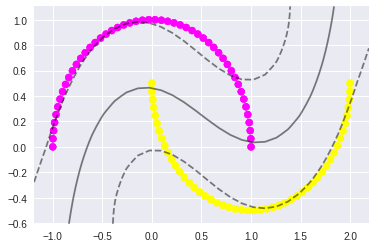

In [32]:
X, y = datasets.make_moons()
plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='spring')

clf = SVC(kernel='rbf').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

### **核函数**的选择是个很复杂的问题。

一般来说， linear 速度快， rbf 表现好、适用性强。

到底采用哪种核函数，请具体问题具体分析。

### SVM的优缺点：

优点：

一、 可以有效解决小样本情况下的机器学习问题，在神经网络主导前曾作为统计派的代表方法大行其道。

二、 加入核方法可以解决非线性问题。

三、 线性回归会对异常值敏感，而SVM对异常值不敏感(抗燥能力,SVM要强)

缺点：

虽然有了核方法，但对各种非线性问题仍没有通用解决方案，必须谨慎选择Kernelfunction来处理。